## Forecasting and Time Series Analysis

Guía utilizada de Kaggle [Forecasting and Time Series Analysis with Python](https://www.kaggle.com/code/yuchengkuo/forecasting-and-time-series-analysis-with-python/notebook)

#### Importaciones

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [27]:
# Función para calcular el MAPE
def mape_(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Carga y preparación del dataset

In [28]:
y = pm.datasets.load_wineind()
datetime_1 = pd.period_range('1980-01', periods=176, freq='M')
dataset_wine = pd.DataFrame(data={'sales': y}, index=datetime_1)

print(dataset_wine.info())
print(dataset_wine.head(n=3))

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 176 entries, 1980-01 to 1994-08
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   176 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB
None
           sales
1980-01  15136.0
1980-02  16733.0
1980-03  20016.0


#### División y Visualización

Train shape: (140, 1), Test shape: (36, 1)


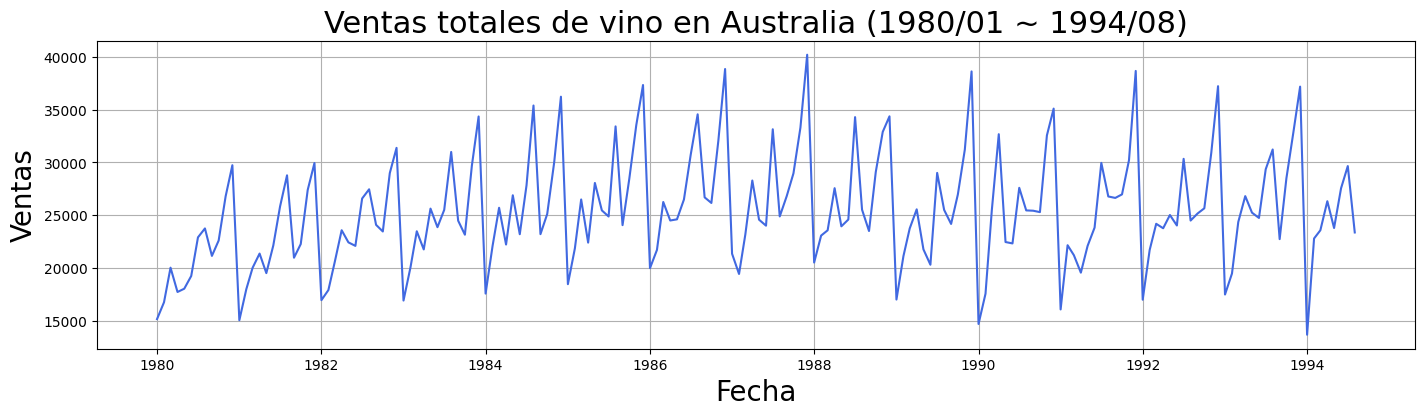

In [29]:
train, test = train_test_split(dataset_wine, train_size=0.8, random_state=2021, shuffle=False)
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

plt.figure(figsize=(17, 4))
plt.plot(dataset_wine.index.to_timestamp(), dataset_wine['sales'], color='royalblue')
plt.title('Ventas totales de vino en Australia (1980/01 ~ 1994/08)', fontsize=22)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Ventas', fontsize=20)
plt.grid(True)
plt.show()

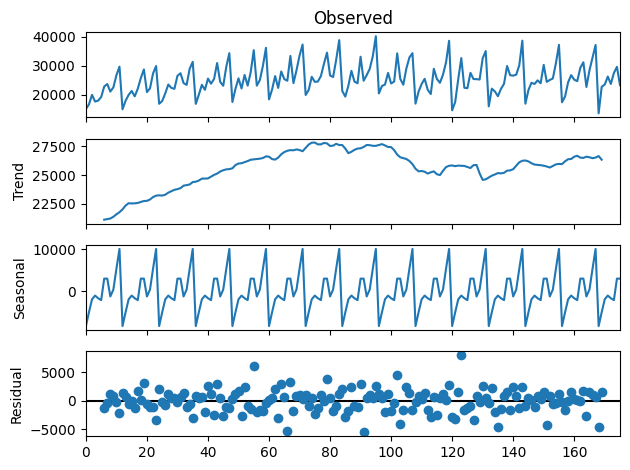

In [30]:
# Descomposición estacional
dataset_wine_array = dataset_wine['sales'].to_numpy()
result = seasonal_decompose(dataset_wine_array, model='additive', period=12)
result.plot()
plt.show()

#### Descomposición estacional

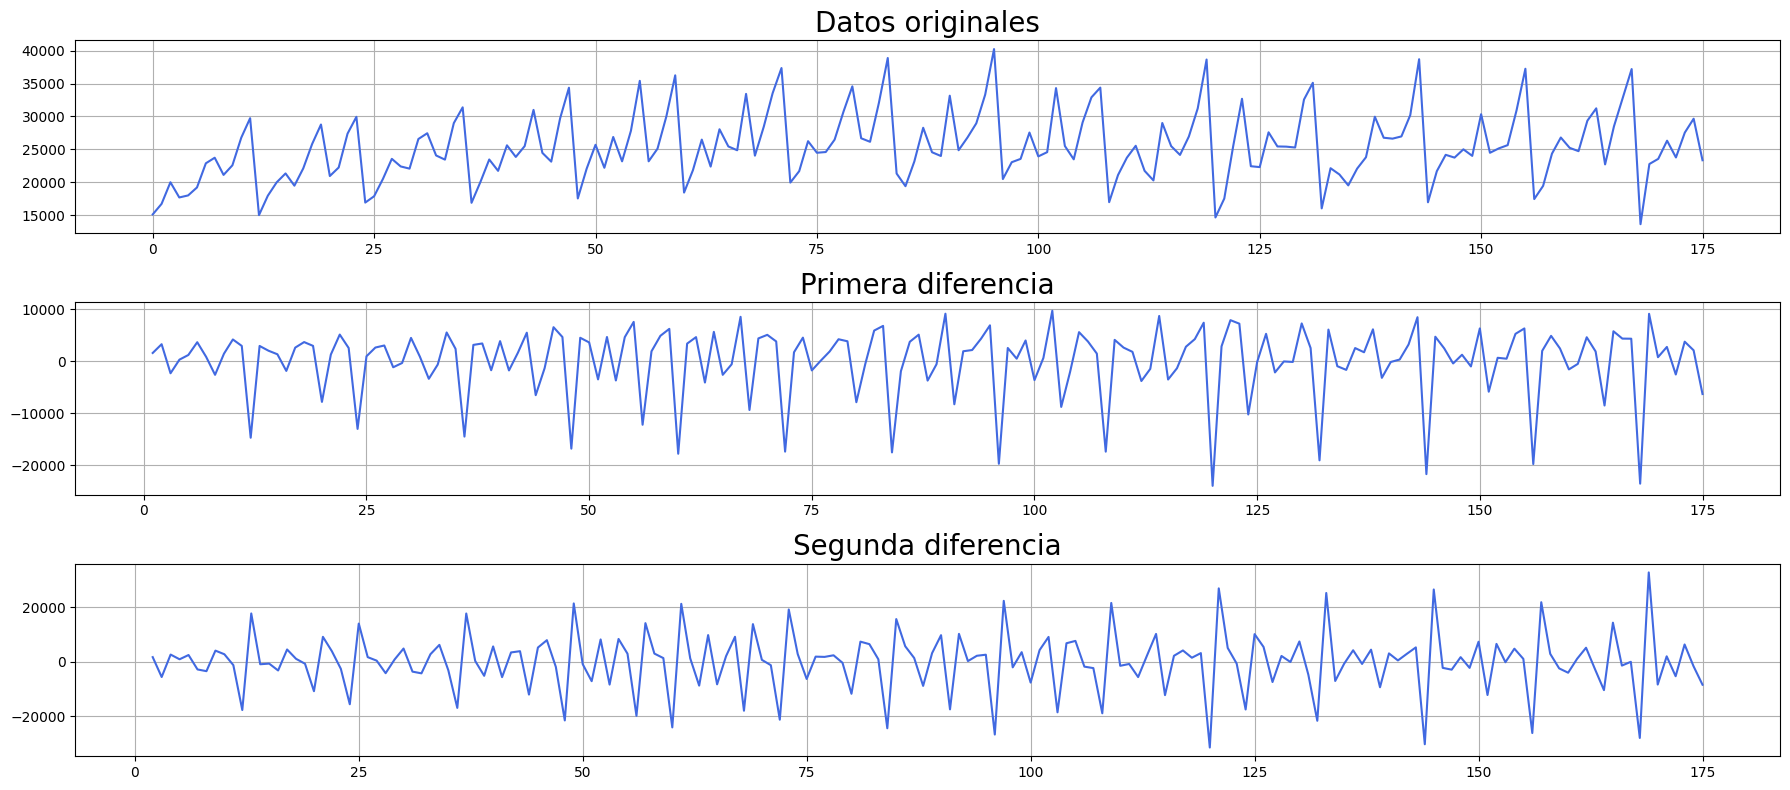

In [31]:
# Comprobación de estacionariedad con diferenciación
dataset_wine_series = pd.Series(dataset_wine_array.flatten())
dataset_wine_diff1 = dataset_wine_series.diff().dropna()
dataset_wine_diff2 = dataset_wine_diff1.diff().dropna()

# Visualización de datos diferenciados
plt.figure(figsize=(18, 8))
plt.subplot(3, 1, 1)
plt.plot(dataset_wine_series, color='royalblue')
plt.title('Datos originales', fontsize=20)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(dataset_wine_diff1, color='royalblue')
plt.title('Primera diferencia', fontsize=20)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(dataset_wine_diff2, color='royalblue')
plt.title('Segunda diferencia', fontsize=20)
plt.grid(True)

plt.tight_layout()
plt.show()

#### Modelos de predicción

##### SARIMA

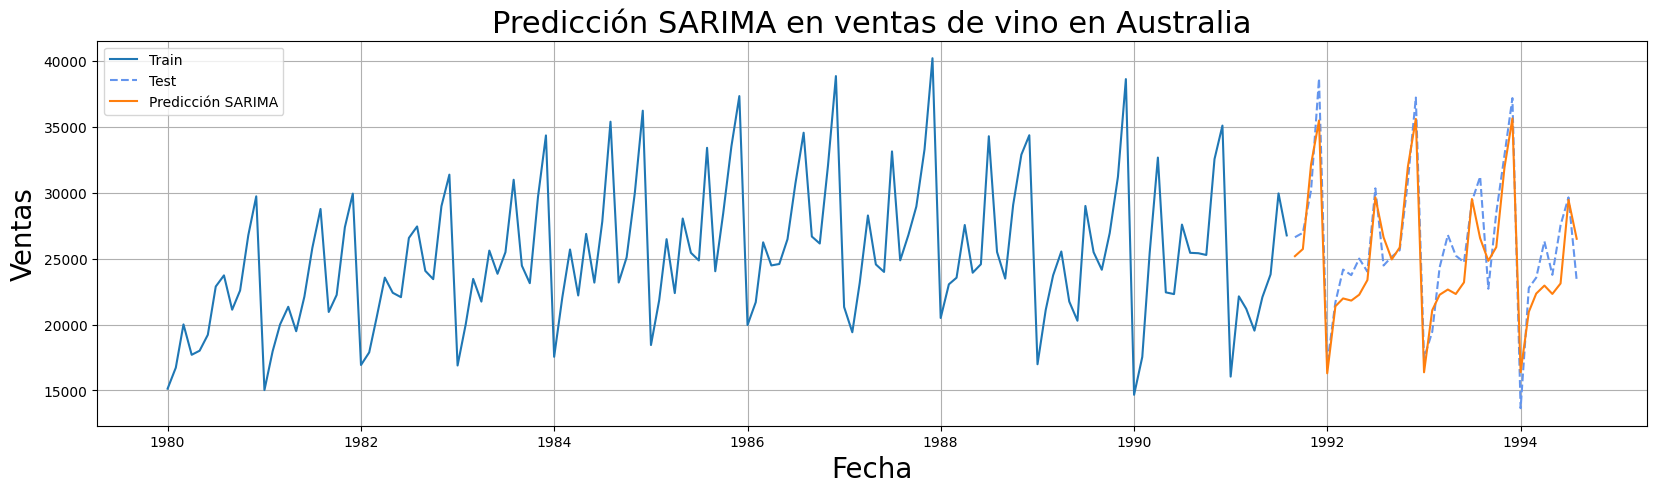

In [32]:
model_SARIMA = SARIMAX(train['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_SARIMA = model_SARIMA.fit()
pred_SARIMA = results_SARIMA.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

plt.figure(figsize=(20, 5))
plt.plot(train.index.to_timestamp(), train['sales'], label='Train', color='tab:blue')
plt.plot(test.index.to_timestamp(), test['sales'], '--', label='Test', color='cornflowerblue')
plt.plot(test.index.to_timestamp(), pred_SARIMA, label='Predicción SARIMA', color='tab:orange')
plt.title('Predicción SARIMA en ventas de vino en Australia', fontsize=22)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Ventas', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [33]:
rmse_SARIMA = sqrt(mean_squared_error(test['sales'], pred_SARIMA))
mae_SARIMA = mean_absolute_error(test['sales'], pred_SARIMA)
mape_SARIMA = mape_(test['sales'], pred_SARIMA)
print(f'SARIMA - RMSE: {rmse_SARIMA:.2f}, MAE: {mae_SARIMA:.2f}, MAPE: {mape_SARIMA:.2f}%')

SARIMA - RMSE: 2182.26, MAE: 1834.31, MAPE: 7.25%


##### Holt-Winters

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


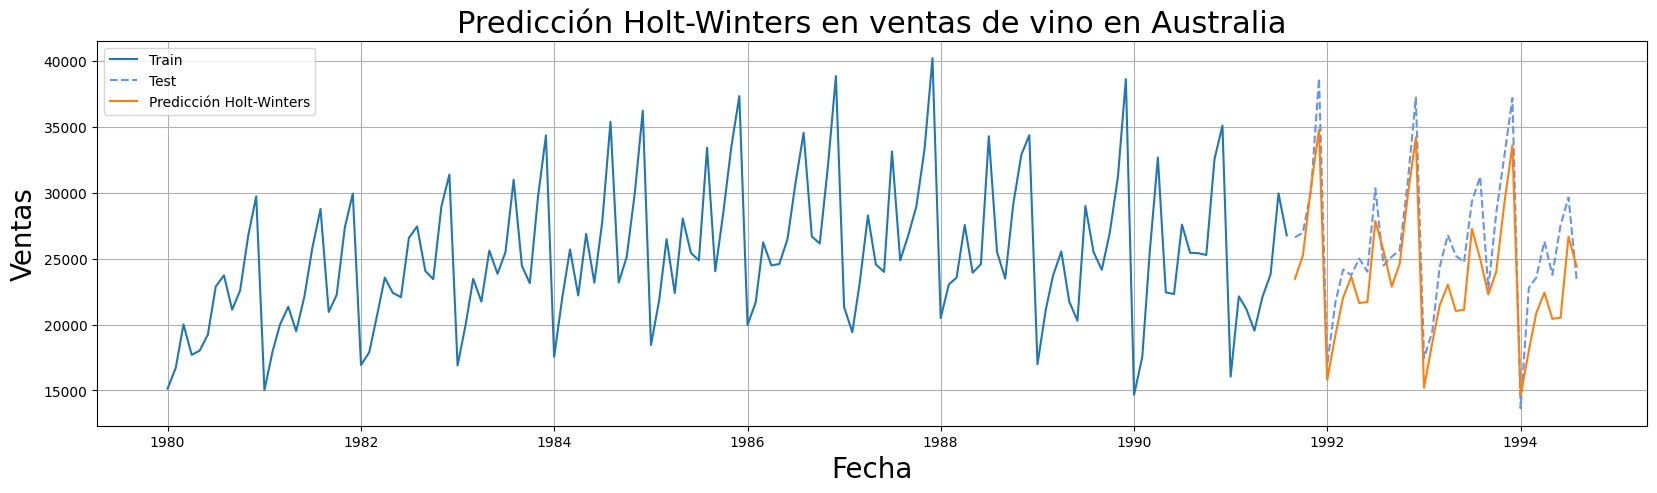

In [34]:
model_HW = ExponentialSmoothing(train['sales'], trend='add', seasonal='add', seasonal_periods=12).fit()
pred_HW = model_HW.predict(start=train.index[-1] + 1, end=test.index[-1])

plt.figure(figsize=(20, 5))
plt.plot(train.index.to_timestamp(), train['sales'], label='Train', color='tab:blue')
plt.plot(test.index.to_timestamp(), test['sales'], '--', label='Test', color='cornflowerblue')
plt.plot(test.index.to_timestamp(), pred_HW, label='Predicción Holt-Winters', color='tab:orange')
plt.title('Predicción Holt-Winters en ventas de vino en Australia', fontsize=22)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Ventas', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [35]:
rmse_HW = sqrt(mean_squared_error(test['sales'], pred_HW))
mae_HW = mean_absolute_error(test['sales'], pred_HW)
mape_HW = mape_(test['sales'], pred_HW)
print(f'Holt-Winters - RMSE: {rmse_HW:.2f}, MAE: {mae_HW:.2f}, MAPE: {mape_HW:.2f}%')

Holt-Winters - RMSE: 3098.60, MAE: 2675.63, MAPE: 10.15%


##### Comparación de modelos

In [36]:
model_evaluation = pd.DataFrame({
    'Modelo': ['SARIMA', 'Holt-Winters'],
    'RMSE': [rmse_SARIMA, rmse_HW],
    'MAE': [mae_SARIMA, mae_HW],
    'MAPE': [mape_SARIMA, mape_HW]
})
print(model_evaluation)

         Modelo         RMSE          MAE       MAPE
0        SARIMA  2182.259755  1834.314066   7.249983
1  Holt-Winters  3098.597532  2675.631180  10.149352
